# AI Practical Assessment (JRP)

Author: Amir Fawwaz

Affliation: HT Consulting (Asia) Sdn. Bhd., Kelana Jaya, Malaysia

Published: 29 July 2024

## Question

Using alexnet as model, train suitable classifier and later compare with Support Vector Machine (SVM). Training shall be done using the following dataset:

- [cifar100](https://keras.io/api/datasets/cifar100/)
- [fruit-data](https://1drv.ms/f/s!ArxRwcm_oQh9gZZ6RKD8azw49Fbrzw?e=zbotuC)
- [potato-data](https://1drv.ms/f/s!ArxRwcm_oQh9gZZ6RKD8azw49Fbrzw?e=zbotuC)

Final evaluation will be perform using usualy confusion matrix.

### Fruit Image Classification with AlexNET

Using knowledge from classification of CIFAR-100, we now extend to bigger images. Skim thru the image dataset, we can see that images are `not in equal resolution`. Thus, following alexnet paper, we standardize all image to fixed resolution of `256 x 256`

In [1]:
!pip install scikit-learn-intelex

In [1]:
# Import Libraries
import tensorflow as tf
from sklearn.svm import SVC
import sklearn
from sklearnex import patch_sklearn 
patch_sklearn()

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

print('The tensorflow version is {}.'.format(tf.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The tensorflow version is 2.10.1.
The scikit-learn version is 1.5.1.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

upload dataset and unzip (e.g. do this once only)

In [ ]:
!mkdir "/content/gdrive/My Drive/fruit"
!unzip -q "/content/gdrive/My Drive/fruit.zip" -d "/content/gdrive/My Drive/fruit"

Images in each folder(class) in around 80-100 each. To split dataset, we manually create 3 folder "train","validation" and "test" following 80%-10%-10% splitting.

In [2]:
data_train_path ="/content/gdrive/My Drive/fruit/train"
data_test_path="/content/gdrive/My Drive/fruit/test"
data_val_path = "/content/gdrive/My Drive/fruit/validation"

# Set the parameters for loading the dataset
batch_size = 32
img_height = 256
img_width = 256

# Create the datasets
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle= True,
    image_size= (img_width, img_height),
    batch_size = batch_size,
    label_mode ='categorical',
    validation_split=False
)

data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=False,
    label_mode ='categorical',
    validation_split=False
)

data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=False,
    label_mode ='categorical',
    validation_split=False
)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [4]:
class_list = data_train.class_names
len(class_list)

36

From data splitting we can see that we have 36 image categories/classes.

## Visualize the data

Here are the 9 images (from 3rd batch) in the validation dataset.

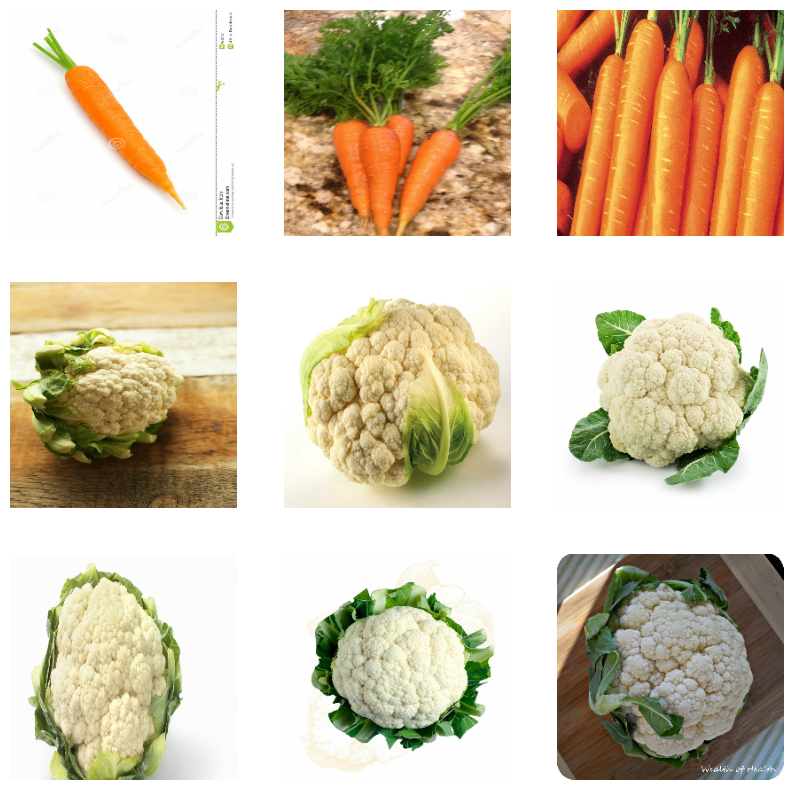

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in data_val.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.axis("off")

In [7]:
# define alexnet model
def my_alexnet(input_shape, num_classes):
    """ model is written in functional API way"""
    inputs = tf.keras.layers.Input(shape=input_shape, name = 'input')

    # Rescaling layers
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # First Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

    # Second Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

    # Third Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Fourth Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Fifth Convolutional Layer
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
    
    # Flatten the output for dense layers
    x = tf.keras.layers.Flatten()(x)
    
    # Fully Connected Layers
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Output Layer  
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="alexnet")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [8]:
# Create the model & display model "stack"
model = my_alexnet(input_shape=(img_width, img_height) + (3,), num_classes=len(class_list))
model.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       6146

In [9]:
%time history = model.fit(data_train, epochs=85, validation_data=data_val, verbose = 0)

Epoch 1/100
98/98 - 15s - loss: 10.6305 - accuracy: 0.0732 - val_loss: 4.7264 - val_accuracy: 0.0769 - 15s/epoch - 149ms/step
Epoch 2/100
98/98 - 12s - loss: 3.8267 - accuracy: 0.1111 - val_loss: 3.1747 - val_accuracy: 0.1311 - 12s/epoch - 121ms/step
Epoch 3/100
98/98 - 12s - loss: 3.6272 - accuracy: 0.1133 - val_loss: 4.3952 - val_accuracy: 0.0769 - 12s/epoch - 121ms/step
Epoch 4/100
98/98 - 12s - loss: 3.4777 - accuracy: 0.1213 - val_loss: 2.8093 - val_accuracy: 0.2051 - 12s/epoch - 124ms/step
Epoch 5/100
98/98 - 12s - loss: 3.2140 - accuracy: 0.1538 - val_loss: 2.5725 - val_accuracy: 0.2422 - 12s/epoch - 123ms/step
Epoch 6/100
98/98 - 12s - loss: 3.1481 - accuracy: 0.1509 - val_loss: 3.3416 - val_accuracy: 0.1225 - 12s/epoch - 125ms/step
Epoch 7/100
98/98 - 12s - loss: 3.1180 - accuracy: 0.1798 - val_loss: 2.7392 - val_accuracy: 0.2422 - 12s/epoch - 127ms/step
Epoch 8/100
98/98 - 12s - loss: 3.0563 - accuracy: 0.1701 - val_loss: 2.4616 - val_accuracy: 0.3048 - 12s/epoch - 126ms/step

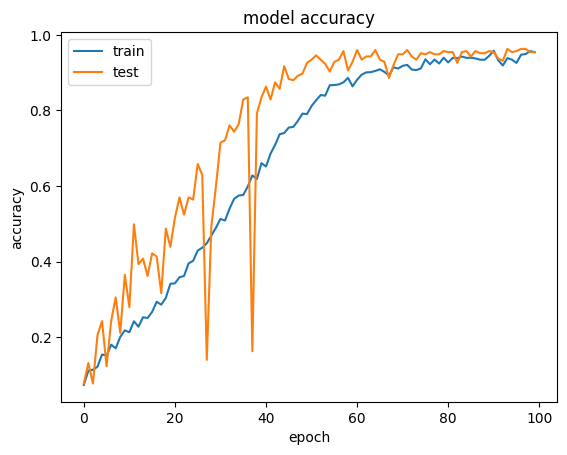

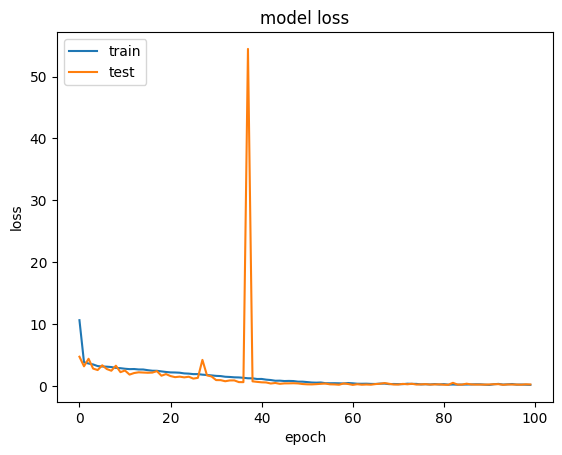

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Model evaluation
test_loss, test_acc = model.evaluate(data_test, verbose=2)

print(f"Test Accuracy: {test_acc*100:.2f}%")

12/12 - 1s - loss: 0.2377 - accuracy: 0.9554 - 1s/epoch - 117ms/step
Test Accuracy: 95.54%


---

## _**Observation 1**_

1. From model accuracy & model loss plot above, we can observed that the trained model show signed of erratic overfitting between epoch 20 to 40. But the model finally generalize well above epoch 60!
2. model training took 19min 55s
3. Model accuracy on _test data_ only give us 95.54% accuracy. And this is good!

### Fruit Image Classification with Support Vector Machine

Now let's perform same classification using SVM from scikit package.

From documentation, `Scikit-learn` provides three classes namely SVC, NuSVC and LinearSVC which can perform multiclass-class classification.

In [3]:
# Convert to NumPy arrays
def process_data(ds):
    x, y = [], []
    
    for images, labels in ds:
        x.append(images.numpy())
        y.append(labels.numpy())
    return np.concatenate(x), np.concatenate(y)

X_train, y_train = process_data(data_train)
X_val, y_val = process_data(data_val)
X_test, y_test = process_data(data_test)

In [4]:
X_train.shape,X_val.shape,X_test.shape

((3115, 256, 256, 3), (351, 256, 256, 3), (359, 256, 256, 3))

From shape above, we shall use validation for SVM fit due to resource constrain, same like cifar-100 previously.

In [5]:
# Feature extraction (simple example: flatten images)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert categorical labels to numerical labels
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

In [7]:
# Train SVM model
print("Training SVM model...")
svm_model = SVC(kernel='rbf', C=1.0, random_state=42, verbose=True)
%time svm_model.fit(X_val_flat, y_val)

Training SVM model...
[LibSVM]CPU times: total: 25.6 s
Wall time: 14.1 s


SVC(random_state=42, verbose=True)

In [9]:
# Test the model
print("Testing the model...")
%time test_predictions = svm_model.predict(X_test_flat)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Testing the model...
CPU times: total: 1min 5s
Wall time: 1min 18s
Test Accuracy: 83.57%


## Final Remark

We have compare 2 type of algorithm/approach to classify 36 categories of images data of fruits. AlexNet model evaluation from _test data_ gives 95.54% accuracy and SVM gives 83.57%.

## Marking Note

Total Mark  = [20 marks]
Estimated time = 45 - 60 minutes

Breakdown:
- format: [1 marks]
- Load Data: [2 marks]
- EDA: [1 marks]*
- Model/Algorithm: [1 marks]
- Successful training: [1 marks]
- Model Evaluation: [10 marks]
- Conclusion/Recommendation: [5 marks]

$^*$optional